In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 182 GB / percent used: 27.6 %


# Check model data

In [2]:
var = 'frac_snow'
folder = 'SRF'
exp = 'clim-without-MVA9'

# Define zone
latlim=(10,50)
lonlim=(60,110)

label, units, cmap, levels = u.get_var_infos(var)

title_1 = 'clim-def'
root_1 = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim'

title_2 = 'clim-without-MVA9'
root_2 = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR_v6.1.11_without_elevation_average/PROD/clim'

## Define paths and period

In [3]:
path_1 = root_1+'/clim-relief-def/'+folder+'/Analyse/TS_MO'
xr.open_mfdataset(path_1+'/*'+var+'.nc', combine='by_coords').time_counter.coords

Coordinates:
    time_centered  (time_counter) object dask.array<chunksize=(144,), meta=np.ndarray>
  * time_counter   (time_counter) object 1980-01-16 00:00:00 ... 1991-12-16 00:00:00

In [4]:
path_2 = root_2+'/clim-relief-def/'+folder+'/Analyse/TS_MO'
xr.open_mfdataset(path_2+'/*'+var+'.nc', combine='by_coords').time_counter.coords

Coordinates:
    time_centered  (time_counter) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time_counter   (time_counter) object 1980-01-16 00:00:00 ... 1989-12-16 00:00:00

In [5]:
# Here the time doesn't make so much sense because the simulation are clim
period = slice('1982','1989')

## Load climatologies

In [6]:
model_1_clim = xr.open_mfdataset(path_1+'/*'+var+'.nc', combine='by_coords'
                                )[var].sel(time_counter=period).mean('time_counter')
model_1_clim.load()

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'frac_snow' (lat: 143, lon: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

In [7]:
model_2_clim = xr.open_mfdataset(path_2+'/*'+var+'.nc', combine='by_coords'
                                )[var].sel(time_counter=period).mean('time_counter')
model_2_clim.load()

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'frac_snow' (lat: 143, lon: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

# Load obs
## NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756

In [8]:
obs_longname = 'NOAA Climate Data Record (CDR) Version 1'
obs_name = 'NOAA CDR'

ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc'
                           ).sel(time=period).mean('time')
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs_clim = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs_clim.attrs['units'] = '%'
obs_clim = obs_clim.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid
# obs = obs.resample(time='1MS').mean('time', skipna='False', keep_attrs=True) # Resamble data per month (from per week)
obs_clim.load()

<xarray.DataArray 'snow_cover_extent' (rows: 88, cols: 88)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    snow_cover_threshold  float32 0.42
    lat                   (rows, cols) float64 0.6592 1.322 ... 1.322 0.6592
    lon                   (rows, cols) float64 145.0 144.3 ... -35.67 -35.0
Dimensions without coordinates: rows, cols
Attributes:
    units:    %

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 

In [10]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

regridder_obs = xe.Regridder(obs_clim, model_1_clim, 'bilinear', periodic=False, reuse_weights=True)
regridder_obs = add_matrix_NaNs(regridder_obs)
obs_clim_regrid = regridder_obs(obs_clim)

Create weight file: bilinear_88x88_143x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# Plot differences

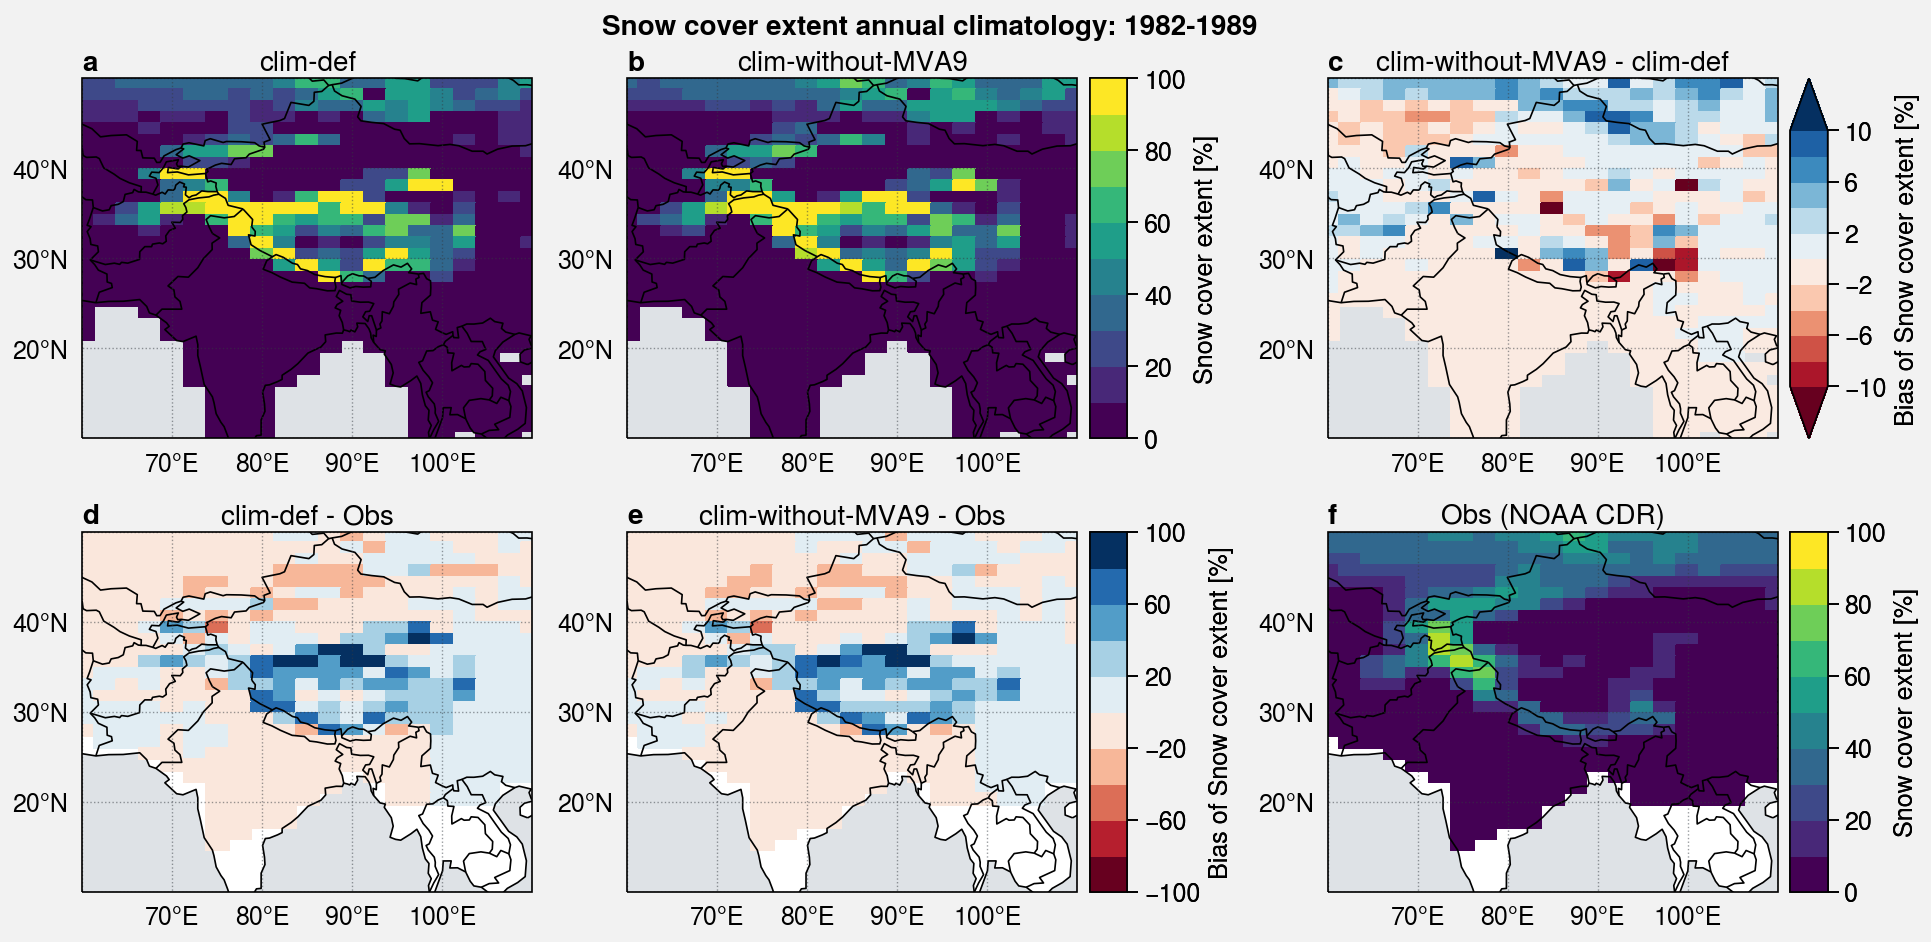

In [17]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=2)

levels_diff = plot.arange(-10,10,2)
cmap_diff = 'BuRd_r'
extend_diff = 'both'

levels_bias = plot.arange(-100,100,20)
cmap_bias = 'BuRd_r'
extend_bias = 'neither'

# First row: differences
axs[0].pcolormesh(model_1_clim, cmap=cmap, levels=levels)
axs[0].format(title=title_1)

m1 = axs[1].pcolormesh(model_2_clim, cmap=cmap, levels=levels)
axs[1].format(title=title_2)
axs[1].colorbar(m1, label=label+ ' ['+units+']')

m2 = axs[2].pcolormesh(model_2_clim - model_1_clim, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[2].format(title=title_2+' - '+title_1)
axs[2].colorbar(m2, label='Bias of '+label+ ' ['+units+']')


# Second row: bias with obs

m3 = axs[3].pcolormesh(model_1_clim - obs_clim_regrid, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[3].format(title=title_1+' - Obs')

axs[4].pcolormesh(model_2_clim - obs_clim_regrid, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[4].format(title=title_2+' - Obs')
axs[4].colorbar(m3, label='Bias of '+label+ ' ['+units+']')

axs[5].pcolormesh(obs_clim_regrid, cmap=cmap, levels=levels)
axs[5].format(title='Obs ('+obs_name+')')
axs[5].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=label+" annual climatology: "+period.start+"-"+period.stop,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'_'+exp+'_'+period.start+'-'+period.stop+'.jpg')
# f.save('img/'+var+'_'+exp+'_'+period.start+'-'+period.stop+'.png')
# f.save('img/'+var+'_'+exp+'_'+period.start+'-'+period.stop+'.pdf')